In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd "/content/gdrive/MyDrive/deep_learning_project/"
!pip install import-ipynb

/content/gdrive/.shortcut-targets-by-id/1qVgfaA1yUyO3mfj4iQgBT95M8G5EAF0v/deep_learning_project


In [ ]:
def load_siamese_dataset( path ):
    images = np.load(os.path.join(train_path, path + '_tensor.npy'))
    labels = np.load(os.path.join(train_path, path +'_labels.npy'))
    
    baseline = images[0::2]
    images = images[1::2]
    labels = labels[1::2]

    dataset = []

    for i in range(len(labels)):
        dataset.append([images[i], baseline[i]])
    
    dataset = np.array(dataset)
    return dataset, labels

def oversample_set(images,labels):
  indexes_0 = []
  indexes_1 = []

  for i in range(len(labels)):
    if(labels[i]==0):
      indexes_0.append(i)
    else:
      indexes_1.append(i)
  
  difference = (len(indexes_0)-len(indexes_1))
  images = images.tolist()
  labels = labels.tolist()

  if(difference>0):
    print("Oversampling on label 1")
    random_indexes = np.random.choice(indexes_1,difference,replace=True)
    for index in random_indexes:
      images.append(images[index])
      labels.append(labels[index])
  else:
    print("Oversampling on label 0")
    random_indexes = np.random.choice(indexes_0,abs(difference),replace=True)
    for index in random_indexes:
      images.append(images[index])
      labels.append(labels[index])

  return np.array(images), np.array(labels)

def enhance_set( dataset, abn = True, bsln = True ):
    enhanced_dataset = []

    en_abn = np.array(dataset[:, 0])
    en_bsln = np.array(dataset[:, 1])
    
    print(np.shape(en_abn))
    print(np.shape(en_bsln))
    
    if abn:
        en_abn = enhance_image( en_abn )
        en_abn = filter_dataset( en_abn )
    else:
        en_abn = enhance_contrast( en_abn )
    if bsln:
        en_bsln = enhance_image( en_bsln )
        en_bsln = filter_dataset( en_bsln )
    else:
        en_blsn = enhance_contrast( en_bsln )
        
    enhanced_dataset = []
    for i in range(len(dataset)):
        enhanced_dataset.append([en_abn[i], en_bsln[i]])
    return np.array(enhanced_dataset)

# IMAGE LOADING AND DATASET SAVING

importing Jupyter notebook from utils.ipynb


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


------------------------------------------------
original distribution


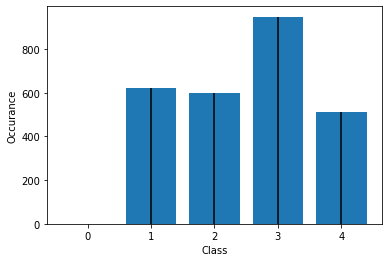

------------------------------------------------
testing set


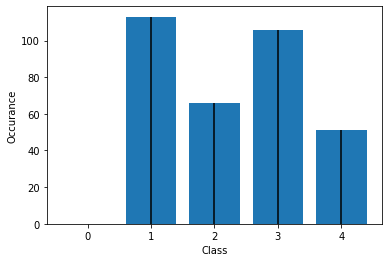

In [ ]:
import import_ipynb
from utils import *
from PIL import Image, ImageEnhance
import tensorflow as tf

training_set, training_labels = load_siamese_dataset( 'train' )
testing_set, testing_labels= load_siamese_dataset( 'public_test' )

labels_distribution(training_labels,"original distribution")
labels_distribution(testing_labels,"testing set")

# Dataset Traduction

------------------------------------------------
traducted training


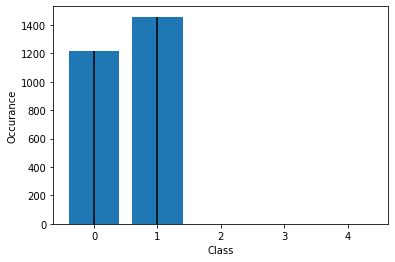

------------------------------------------------
traducted testing


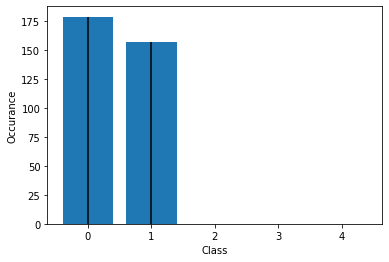

In [ ]:
training_labels = label_traduction(training_labels,1)
testing_labels = label_traduction(testing_labels,1)

labels_distribution(training_labels,"traducted training")
labels_distribution(testing_labels,"traducted testing")


# Preprocessing


(2676, 150, 150)
(2676, 150, 150)
(336, 150, 150)
(336, 150, 150)
Oversampling on label 0
------------------------------------------------
oversampled distribution


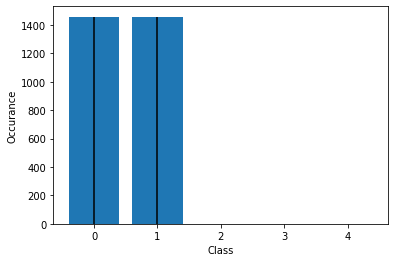

------------------------------------------------
oversampled distribution shuffled


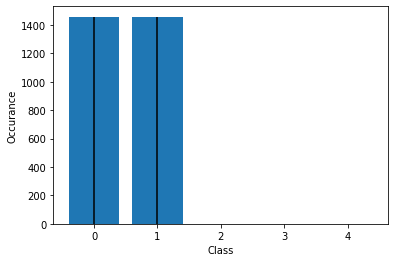

(2916, 2, 150, 150)


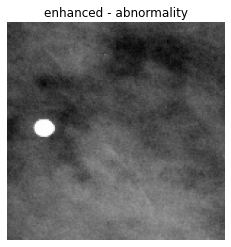

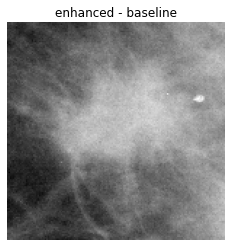

In [ ]:
#enhancing
training_set = enhance_set(training_set, False, False)
testing_set = enhance_set(testing_set, False, False)

#oversampling
training_set, training_labels = oversample_set(training_set, training_labels)
labels_distribution(training_labels, "oversampled distribution")

#shuffling
training_set,training_labels = shuffle_data(training_set, training_labels)
labels_distribution(training_labels,"oversampled distribution shuffled")

print(np.shape(training_set))
visualize_image(training_set[0][1],"enhanced - abnormality")
visualize_image(training_set[0][0],"enhanced - baseline")

# Dataset importing

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


TRAIN_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/train"
TEST_DATA_DIR = "/content/gdrive/MyDrive/deep_learning_project/dataset/2.1/test"
BATCH_SIZE = 32
NORMALIZATION = 65536

In [ ]:
temp = []
for s in training_set:
    temp.append([s[0]/NORMALIZATION, s[1]/NORMALIZATION])

training_set = np.array(temp)
temp = []

temp = []
for s in testing_set:
    temp.append([s[0]/NORMALIZATION, s[1]/NORMALIZATION])

testing_set = np.array(temp)

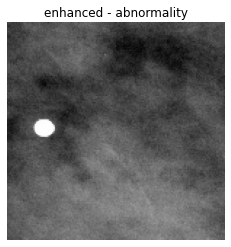

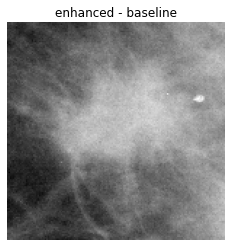

(2916, 2, 150, 150)
(336, 2, 150, 150)


In [ ]:
visualize_image(training_set[0][1],"enhanced - abnormality")
visualize_image(training_set[0][0],"enhanced - baseline")

print(np.shape(training_set))
print(np.shape(testing_set))


In [ ]:
splitted_train_set, splitted_val_set, splitted_train_labels, splitted_val_labels = train_test_split(training_set, training_labels, test_size=0.2, stratify=training_labels)

print(np.shape(splitted_train_set))
print(np.shape(splitted_val_set))

(2332, 2, 150, 150)
(584, 2, 150, 150)


# CNN Model Construction

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

def model_setup():
    model_input = tf.keras.Input(shape=(150,150,1))
    # preprocessing layers
    
    embedding = layers.experimental.preprocessing.RandomRotation(factor=0.25, seed=123, fill_mode='nearest')(model_input)
    embedding = layers.experimental.preprocessing.RandomFlip(mode='horizontal', seed=123)(embedding)
    
    # scratch model layers
    embedding = layers.Conv2D(32, (3, 3), activation='relu')(embedding)
    embedding = layers.MaxPooling2D(2, 2)(embedding)
    embedding = layers.Conv2D(64, (3, 3), activation='relu')(embedding)
    embedding = layers.MaxPooling2D(2, 2)(embedding)

    embedding = layers.Conv2D(128, (3, 3), activation='relu')(embedding)
    embedding = layers.Conv2D(128, (3, 3), activation='relu')(embedding)
    embedding = layers.MaxPooling2D(2, 2)(embedding)

    embedding = layers.Flatten()(embedding)
    embedding = layers.Dense(512, activation='relu')(embedding)

    return models.Model(model_input, embedding, name='Siamese')

In [ ]:
input_shape=(150, 150, 1)

abnormalities_input = layers.Input(input_shape, name="Abnormalities")
baselines_input = layers.Input(input_shape, name="Baselines")

siamese_model = model_setup()
features_abn = siamese_model(abnormalities_input)
features_bsln = siamese_model(baselines_input)

concatenation = layers.Concatenate(name='Concatenation')([features_abn, features_bsln])
dropout = layers.Dropout(0.4)(concatenation)
dense = layers.Dense(512, activation='relu')(dropout)
sigmoid = layers.Dense(1, activation='sigmoid')(dense)

siamese_net = models.Model(inputs=[abnormalities_input, baselines_input], outputs=sigmoid, name='Siamese-Network')

siamese_net.summary()

Model: "Siamese-Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Abnormalities (InputLayer)      [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
Baselines (InputLayer)          [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
Siamese (Functional)            (None, 512)          17017984    Abnormalities[0][0]              
                                                                 Baselines[0][0]                  
__________________________________________________________________________________________________
Concatenation (Concatenate)     (None, 1024)         0           Siamese[0][0]      

# Model Compile

In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers


siamese_net.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



# Model Fitting

In [ ]:
print(np.shape(splitted_val_set))
print(np.shape(splitted_val_labels))

val_dataset0 = tf.data.Dataset.from_tensor_slices( splitted_val_set[:,0] )
val_dataset1 = tf.data.Dataset.from_tensor_slices( splitted_val_set[:,1] )
val_dataset = tf.data.Dataset.zip((val_dataset0, val_dataset1))
lab_dataset = tf.data.Dataset.from_tensor_slices(splitted_val_labels)
val_dataset = tf.data.Dataset.zip((val_dataset, lab_dataset ))


val_set = [splitted_val_set[:,0], splitted_val_set[:,1]]

(584, 2, 150, 150)
(584,)


In [ ]:
EPOCHS = 50

history = siamese_net.fit(
    [splitted_train_set[:,0],splitted_train_set[:,1]],
    splitted_train_labels, 
    epochs = EPOCHS,
    validation_data = (val_set, splitted_val_labels),
    batch_size = 50
    )

Epoch 1/50
47/47 [==============================] - 293s 6s/step - loss: 0.7110 - accuracy: 0.5232 - val_loss: 0.6858 - val_accuracy: 0.5137
Epoch 2/50
47/47 [==============================] - 295s 6s/step - loss: 0.6679 - accuracy: 0.6222 - val_loss: 0.6370 - val_accuracy: 0.6729
Epoch 3/50
47/47 [==============================] - 287s 6s/step - loss: 0.6456 - accuracy: 0.6398 - val_loss: 0.6575 - val_accuracy: 0.7329
Epoch 4/50
47/47 [==============================] - 288s 6s/step - loss: 0.6123 - accuracy: 0.6883 - val_loss: 0.6054 - val_accuracy: 0.6935
Epoch 5/50
47/47 [==============================] - 289s 6s/step - loss: 0.5497 - accuracy: 0.7320 - val_loss: 0.6006 - val_accuracy: 0.7380
Epoch 6/50
47/47 [==============================] - 288s 6s/step - loss: 0.5486 - accuracy: 0.7389 - val_loss: 0.5385 - val_accuracy: 0.7637
Epoch 7/50
47/47 [==============================] - 288s 6s/step - loss: 0.5337 - accuracy: 0.7389 - val_loss: 0.5517 - val_accuracy: 0.7123
Epoch 8/50
47

#Model Saving

In [ ]:
import pickle

path = "/content/gdrive/MyDrive/deep_learning_project/models/4/"
model_name = "Siamese_Net_Copy"

siamese_net.save( path + model_name + ".h5")

with open(path + model_name + "_history.pickle", 'wb') as file_pi:
        pickle.dump(history.history,  file_pi)

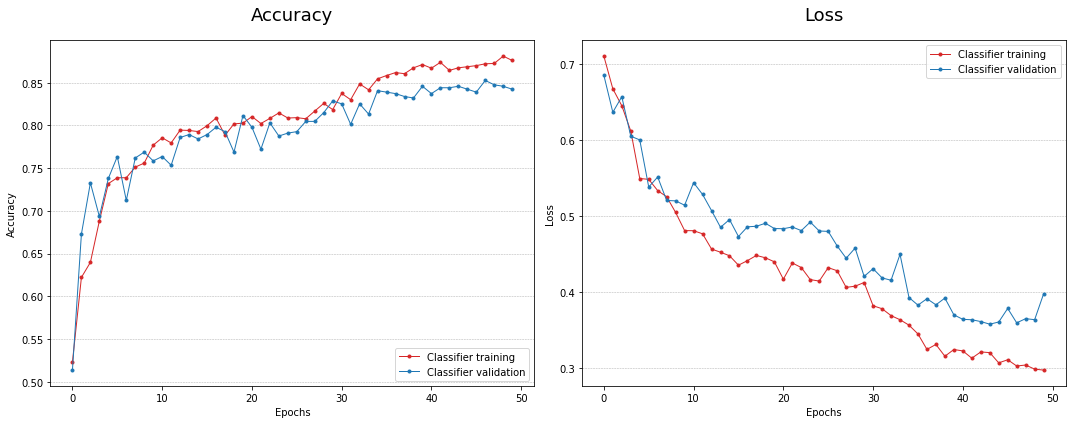

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# create figure
fig, (acc_g,loss_g) = plt.subplots(1,2, figsize=(15,6))

# range for x axis
epochs = range(len(acc))

# plot accuracy curves
acc_g.plot(epochs, acc, color='tab:red', marker='.', linestyle='-', label='Classifier training', linewidth=1)
acc_g.plot(epochs, val_acc, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)

# plot loss curves
loss_g.plot(epochs, loss, color='tab:red', marker='.', linestyle='-', label='Classifier training ', linewidth=1)
loss_g.plot(epochs, val_loss, color='tab:blue', marker='.', linestyle='-', label='Classifier validation', linewidth=1)

# accuracy graph style options
acc_g.grid(axis='y', linestyle='--', linewidth=0.5)
acc_g.set_xlabel('Epochs')
acc_g.set_ylabel('Accuracy')
acc_g.set_title('Accuracy', fontdict={'fontsize':18}, pad=20)
acc_g.legend(loc='lower right')

# loss graph style options
loss_g.grid(axis='y', linestyle='--', linewidth=0.5)
loss_g.set_xlabel('Epochs')
loss_g.set_ylabel('Loss')
loss_g.set_title('Loss', fontdict={'fontsize':18}, pad=20)
loss_g.legend(loc='upper right')

# layout adjustment
plt.tight_layout()

In [ ]:
test_loss, test_accuracy = siamese_net.evaluate(
    x=[testing_set[:,0], testing_set[:,1]],
    y=testing_labels,
    batch_size=BATCH_SIZE
)
print("Test loss", test_loss)
print("Test accuracy",test_accuracy)

11/11 [==============================] - 11s 970ms/step - loss: 0.4174 - accuracy: 0.8185
Test loss 0.41735485196113586
Test accuracy 0.8184523582458496


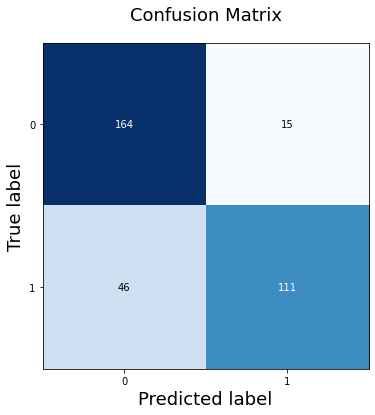

precision score:  0.8809523809523809
recall score:  0.7070063694267515
f2:  0.7360742705570292
f0.5:  0.8396369137670197
classification report: 
               precision    recall  f1-score   support

           0       0.78      0.92      0.84       179
           1       0.88      0.71      0.78       157

    accuracy                           0.82       336
   macro avg       0.83      0.81      0.81       336
weighted avg       0.83      0.82      0.82       336

AUC:  0.8116037433725938


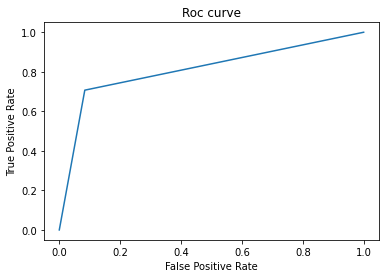

In [ ]:
prediction = siamese_net.predict([testing_set[:,0], testing_set[:,1]])
in_depth_performance(testing_labels,np.where(prediction > 0.5, 1,0)) #np.where is used to conver from probability to binary label

In [ ]:
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

training_images, training_labels= load_training()
testing_images, testing_labels= load_testing()

#new_training_images = np.stack((training_images[0::2],)*3, axis=-1)
new_training_images = np.stack((training_images[1::2],)*3, axis=-1)
new_training_labels = training_labels[1::2]
labels_distribution(new_training_labels)

new_training_labels =  np.array(new_training_labels/3, dtype='int')
labels_distribution(new_training_labels)

new_testing_images = np.stack((testing_images[1::2],)*3, axis=-1)
new_testing_labels = testing_labels[1::2]
labels_distribution(new_testing_labels)

new_testing_labels =  np.array(new_testing_labels/3, dtype='int')
labels_distribution(new_testing_labels)

splitted_train_images, splitted_val_images, splitted_train_labels, splitted_val_labels = train_test_split(new_training_images, new_training_labels,
                                                  test_size=0.3, 
                                                  stratify=new_training_labels)

#datagen = ImageDataGenerator(
#  )

labels_distribution(splitted_train_labels)
labels_distribution(splitted_val_labels)


tr_tensor = datagen.flow( splitted_train_images, splitted_train_labels, subset = "training" )
val_tensor = datagen.flow( splitted_val_images, splitted_val_labels, subset = "validation" )
te_tensor = datagen.flow(new_testing_images, new_testing_labels,)


train_datagen = ImageDataGenerator(
    validation_split=0.3
    )

tr_tensor = train_datagen.flow( new_training_images, new_training_labels, subset = "training" )
val_tensor = train_datagen.flow( new_training_images, new_training_labels, subset = "validation" )


test_datagen = ImageDataGenerator(
  )

te_tensor = test_datagen.flow(new_testing_images, new_testing_labels,)
'''

'\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\nfrom sklearn.model_selection import train_test_split\nimport numpy as np\n\ntraining_images, training_labels= load_training()\ntesting_images, testing_labels= load_testing()\n\n#new_training_images = np.stack((training_images[0::2],)*3, axis=-1)\nnew_training_images = np.stack((training_images[1::2],)*3, axis=-1)\nnew_training_labels = training_labels[1::2]\nlabels_distribution(new_training_labels)\n\nnew_training_labels =  np.array(new_training_labels/3, dtype=\'int\')\nlabels_distribution(new_training_labels)\n\nnew_testing_images = np.stack((testing_images[1::2],)*3, axis=-1)\nnew_testing_labels = testing_labels[1::2]\nlabels_distribution(new_testing_labels)\n\nnew_testing_labels =  np.array(new_testing_labels/3, dtype=\'int\')\nlabels_distribution(new_testing_labels)\n\nsplitted_train_images, splitted_val_images, splitted_train_labels, splitted_val_labels = train_test_split(new_training_images, new_training_lab